In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm as norm

In [18]:
d1 = pd.read_csv("./data/Skin_NonSkin.txt", sep="\t", header=None)
X = d1.values[:,:-1]
Y = d1.values[:,-1]

In [19]:
Xs = np.sum(X,1)
Xs = np.maximum(Xs,np.ones_like(Xs))
np.min(Xs)
X_reg = (X.T/Xs).T

Y_reg = 2*Y - 3

In [11]:
#Perceptron
#def perceptron(X_reg, Y_reg):
i = 0
w = np.zeros_like(X[0,:])
metric = []
I = []
for x,y in zip(X_reg,Y_reg):
    #import pdb; pdb.set_trace()
    l = y - np.sign(np.sum(w*x))
    w_new = w + l*x
    if np.linalg.norm(w) != 0:
        metric.append(norm(w_new/norm(w_new) - w/(norm(w))))
        I.append(i)
    w = w_new
    i+=1

In [12]:
w

array([0.4523901, 0.413383 , 0.1342269])

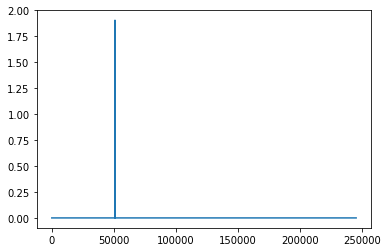

In [13]:
plt.plot(I,metric); plt.show()

In [20]:
#Winnow
i = 0
eta = 0.05
w = np.ones_like(X[0,:])
w = w/np.sum(w)
metric = []
I = []
for x,y in zip(X_reg,Y_reg):
    l = y - np.sign(np.sum(w*x))
    if l != 0:
        w_new = w*np.exp(eta*x*y)
        w_new = w_new/np.sum(w_new)
        metric.append(norm(w_new/norm(w_new) - w/(norm(w))))
        I.append(i)
        w = w_new
    i+=1

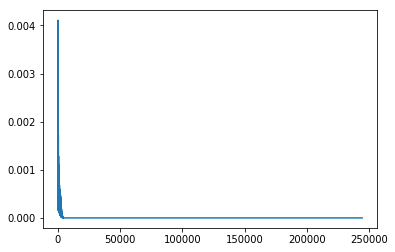

In [21]:
plt.plot(I,metric)

In [22]:
w

array([1.00000000e+000, 4.46114930e-086, 9.30773854e-231])

In [23]:
np.min(np.sign(np.sum(w*X_reg,1)))

0.0